In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#압축파일 풀 곳
%cd /content/drive/MyDrive/ai project 4-1
#데이터있는 주소
#!unzip -qq "/content/drive/MyDrive/ai project 4-1/data.zip"

/content/drive/MyDrive/ai project 4-1
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
no
[n]o
n


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# RLE 디코딩 함수, 인코딩 되어있는 string을 이미지형태로 변환하고자 함
def rle_decode(mask_rle, shape):
  #mask를 분할함
    s = mask_rle.split()
    #RLE 방식에 따라 시작 픽셀 지점과 그 길이를 각각 저장 (짝수 홀수로 묶어 저장)
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    #starts자리에서 1의 데이터가 시작되고 ends자리에서 1의 데이터가 끝난다.
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    #인코딩하여 압축한 1의 데이터를 할당하여 복원한다.
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
  #2차원모양을 1차원으로 펼침
    pixels = mask.flatten()
    #여기서 왜 앞뒤에 0을 할당하는지는 모르게씀
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    #runs[1::2]= 인덱스 1부터 2씩증가시키며 가져옴 / runs[::2]=리스트 전체에서 인덱스 0부터 2씩 증가시키면서 요소를 가져옴
    runs[1::2] -= runs[::2]
    #join함수로 하나의 문자열로 만들어준다.
    return ' '.join(str(x) for x in runs)

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


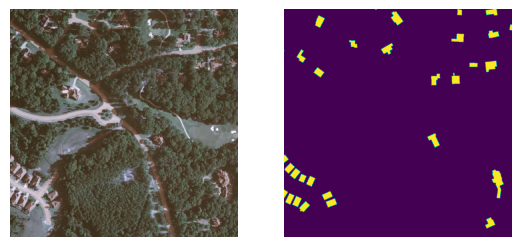

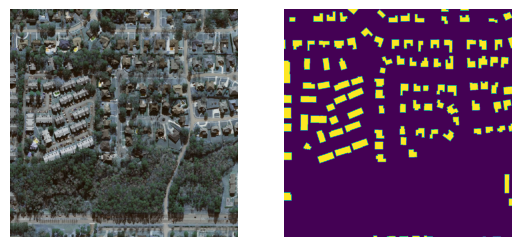

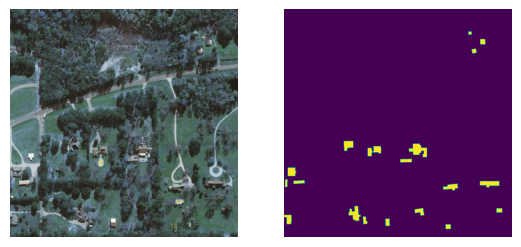

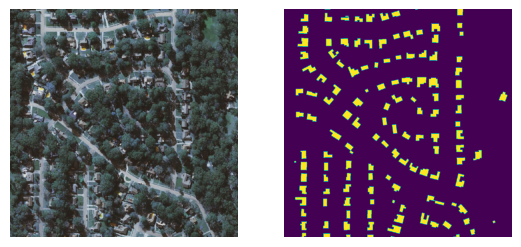

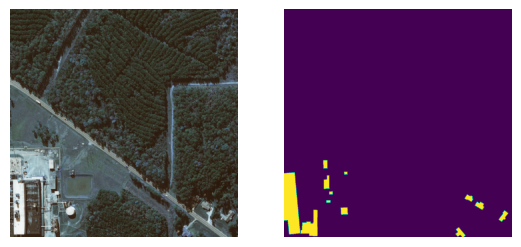

In [ ]:
#돌린 결과 test set 관찰 하기

#이미지를 불러올 폴더 위치 설정

train_data = pd.read_csv('train.csv')

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#관찰할 범위 입력
for i in range(285,290):
  train_image_path = train_data['img_path'][i]
  train_image = cv2.imread(train_image_path)
  train_mask = rle_decode(train_data['mask_rle'][i], (1024,1024))


  plt.figure(figsize=(10,10))
  plt.subplot(131)
  plt.imshow(train_image)
  plt.axis("off")
  plt.subplot(132)
  plt.imshow(train_mask)
  plt.axis("off")


**model**

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(20):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

100%|██████████| 447/447 [04:42<00:00,  1.58it/s]


Epoch 1, Loss: 0.16789826935769728


100%|██████████| 447/447 [04:34<00:00,  1.63it/s]


Epoch 2, Loss: 0.11804065393321467


100%|██████████| 447/447 [04:35<00:00,  1.62it/s]


Epoch 3, Loss: 0.10017881409933903


100%|██████████| 447/447 [04:38<00:00,  1.60it/s]


Epoch 4, Loss: 0.09005508686038738


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 5, Loss: 0.08389182218769253


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 6, Loss: 0.07995888949173942


100%|██████████| 447/447 [04:36<00:00,  1.62it/s]


Epoch 7, Loss: 0.07692918299761928


100%|██████████| 447/447 [04:35<00:00,  1.63it/s]


Epoch 8, Loss: 0.07297270250833808


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 9, Loss: 0.0714728068518692


100%|██████████| 447/447 [04:36<00:00,  1.61it/s]


Epoch 10, Loss: 0.06910432589300794


100%|██████████| 447/447 [04:35<00:00,  1.62it/s]


Epoch 11, Loss: 0.06753058669884467


100%|██████████| 447/447 [04:39<00:00,  1.60it/s]


Epoch 12, Loss: 0.0646965764879647


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 13, Loss: 0.06430933336983591


100%|██████████| 447/447 [04:37<00:00,  1.61it/s]


Epoch 14, Loss: 0.06368891201429985


100%|██████████| 447/447 [04:36<00:00,  1.62it/s]

Epoch 15, Loss: 0.0649445497699632


In [ ]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [16:46<00:00,  3.77it/s]


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result
submit.to_csv('/sample_submission.csv', index=False)

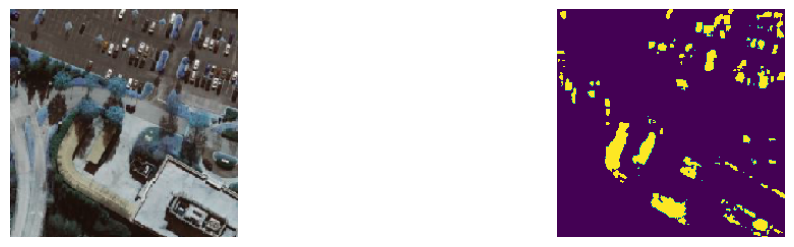

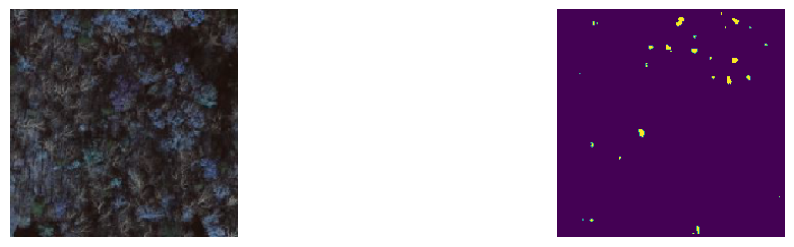

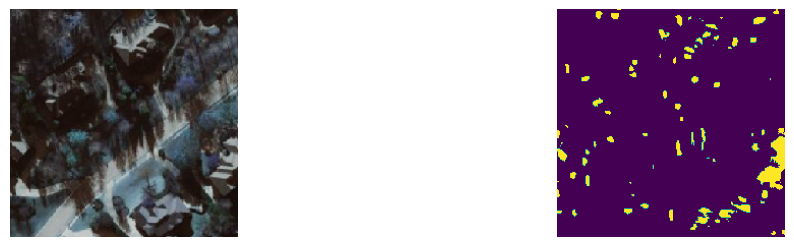

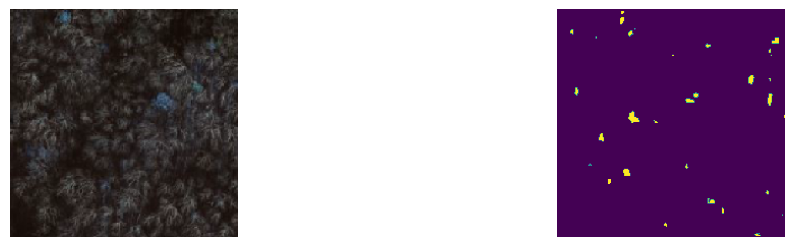

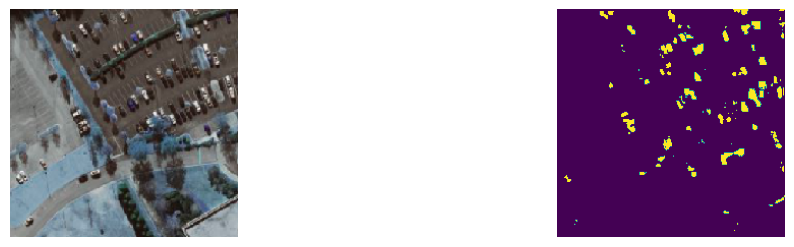

In [ ]:
#돌린 결과 test set 관찰 하기

#이미지를 불러올 폴더 위치 설정

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
#test 결과물
sub_data = pd.read_csv('submit.csv')
#sub_data2 = pd.read_csv('epoch15.csv')

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

#관찰할 범위 입력
for i in range(285,290):
  testimage_path = test_data['img_path'][i]
  test_image = cv2.imread(testimage_path)
  #224는 이미지 사이즈인데 tuple 오류때문에 일단 수기로 적었음 들어오는 이미지 사이즈에 따라 수정필요
  submit_mask = rle_decode(sub_data['mask_rle'][i], (224,224))
  #submit_mask2 = rle_decode(sub_data2['mask_rle'][i], (224,224))

  plt.figure(figsize=(10,10))
  plt.subplot(131)
  plt.imshow(test_image)
  plt.axis("off")
 # plt.subplot(132)
 # plt.imshow(submit_mask2)
 # plt.axis("off")
  plt.subplot(133)
  plt.imshow(submit_mask)
  plt.axis("off")
  plt.show()
  plt.close()